In [95]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from tqdm import tqdm
from torch.utils.data import Dataset

import os
import tifffile
import trackpy as tp
import warnings
import logging

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    torch.cuda.empty_cache()
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce RTX 3080
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Load Data

In [3]:
def get_PSF_frame(movie_frame, x, y, frame_size, keep_edges=False):
    half_frame = int(frame_size/2)
    int_x = round(x); int_y = round(y)
    lower_x = int_x - half_frame
    lower_y = int_y - half_frame
    upper_x = int_x + half_frame + 1
    upper_y = int_y + half_frame + 1
    upper_limit_x = movie_frame.shape[1]
    upper_limit_y = movie_frame.shape[0]
    if keep_edges:
        if lower_x < 0:
            lower_x = 0
        if lower_y < 0:
            lower_y = 0
        if upper_x > upper_limit_x:
            upper_x = upper_limit_x
        if upper_y > upper_limit_y:
            upper_y = upper_limit_y
    else:
        if lower_x < 0 or lower_y < 0 or upper_x > upper_limit_x or upper_y > upper_limit_y:
            return False
    return np.array(movie_frame)[lower_y:upper_y, lower_x:upper_x]

def get_PSF_frames(movie, minmass=2000, separation=3, diameter=7, frame_size=13, percentile=0.9, to_plot=False, movie_frames=True, dpi=100):
    if type(movie_frames) == bool:
        movie_frames = range(len(movie))
    
    # Initialize an empty list to store the PSF frames
    PSF_frames = []

    # Loop through each frame in the movie
    for i in movie_frames:
        # Perform localization on the frame
        full_frame = tp.locate(movie[i], diameter=diameter, 
                        minmass=minmass, max_iterations=10,
                        separation=separation, percentile=percentile)  # Adjust the minmass parameter as needed

        # Plot the frame with the identified features
        if to_plot:
            fig, ax = plt.subplots(1, dpi=dpi)
            ax.imshow(movie[i], cmap='gray')

        # Draw a box around each identified feature
        for index, row in full_frame.iterrows():
            if to_plot:
                rect = patches.Rectangle((row['x']-int(frame_size/2), row['y']-int(frame_size/2)), frame_size, frame_size, linewidth=1, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
            PSF_frame = get_PSF_frame(movie[i], row['x'], row['y'], frame_size)
            if type(PSF_frame) == bool:
                continue
            PSF_frames.append(PSF_frame)
        if to_plot:
            plt.title(f'Full Frame {i}')
            plt.show()

    # Convert the list of frames to a numpy array
    PSF_frames = np.array(PSF_frames)
    return PSF_frames

def get_PSF_frames_movie_list(movies, minmass=2000, separation=3, diameter=7, frame_size=13, percentile=0.9):
    first = True
    for movie in movies:
        if first:
            PSF_list = get_PSF_frames(movie, minmass, separation, diameter, frame_size, percentile)
            first = False
        else:
            PSF_list = np.concatenate((PSF_list, get_PSF_frames(movie, minmass, separation, diameter, frame_size, percentile)))
    return PSF_list

def show_PSFs(PSF_frames, random=True):
    print(PSF_frames.shape)
    num_PSFs = 15
    if not random:
        random_seed = 1 # random seed for reproducibility
        np.random.seed(random_seed)
    PSF_indices = np.random.choice(PSF_frames.shape[0], size=num_PSFs, replace=False)
    image_list = PSF_frames[PSF_indices]

    # Creating a 2x5 subplot grid
    fig, axes = plt.subplots(3, 5, figsize=(10, 4), dpi=150)

    # Flattening the 2D array of axes to a 1D array
    axes = axes.flatten()

    # Iterating over each image and corresponding axis
    for i in range(len(axes)):
        # Displaying the image on the corresponding axis
        axes[i].imshow(image_list[i], cmap='gray')
        axes[i].axis('off')

    plt.suptitle("Examples of PSF Frames", fontsize=24)
    plt.tight_layout()
    plt.show()

def load_tif_movies(folder_path):
    movies = []
    logger = logging.getLogger('tifffile')
    prev_level = logger.getEffectiveLevel()  # get the current logging level
    logger.setLevel(logging.ERROR)  # set level to ERROR, only ERROR level and above will be shown
    try:
        for filename in os.listdir(folder_path):
            # Check if the current file is a .tif file
            if filename.endswith('.tif'):
                # Construct the full filepath by joining the directory path and the filename
                filepath = os.path.join(folder_path, filename)
                movies.append(tifffile.imread(filepath))
    finally:
        logger.setLevel(prev_level)  # reset the logging level to its previous state
    return movies


## Tons of Data for Training

In [4]:
A647_movies = load_tif_movies('Raw Data\A647')
CF660_movies = load_tif_movies('Raw Data\CF660c')
print(len(A647_movies), len(CF660_movies))

8 12


In [5]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=UserWarning)
#     A647_PSFs = get_PSF_frames_movie_list(A647_movies, minmass, separation, diameter, frame_size, percentile)

In [4]:
# with open('PSF Frames\A647_combined_PSFs.npy', 'wb') as f:
#     np.save(f, A647_PSFs)
with open('PSF Frames\A647_combined_PSFs.npy', 'rb') as f:
    A647_PSFs = np.load(f)

(199604, 19, 19)


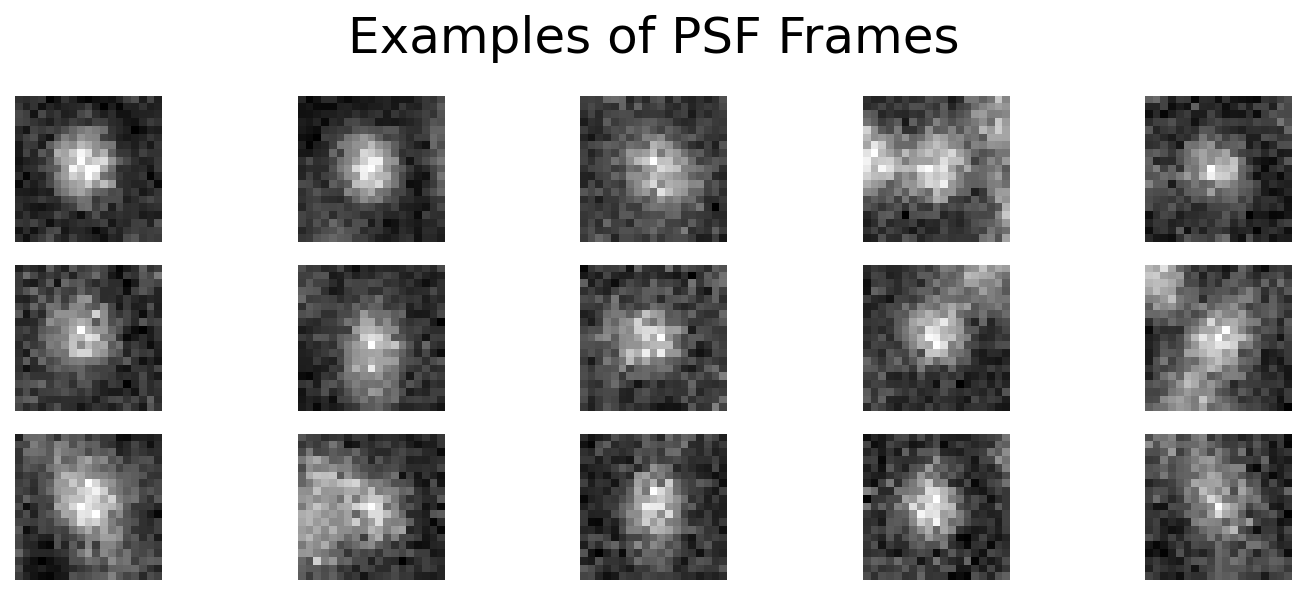

In [7]:
show_PSFs(A647_PSFs)

In [8]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    CF660_PSFs = get_PSF_frames_movie_list(CF660_movies, minmass, separation, diameter, frame_size, percentile)

In [5]:
# with open('PSF Frames\CF660c_combined_PSFs.npy', 'wb') as f:
#     np.save(f, CF660_PSFs)
with open('PSF Frames\CF660c_combined_PSFs.npy', 'rb') as f:
    CF660_PSFs = np.load(f)

(99769, 19, 19)


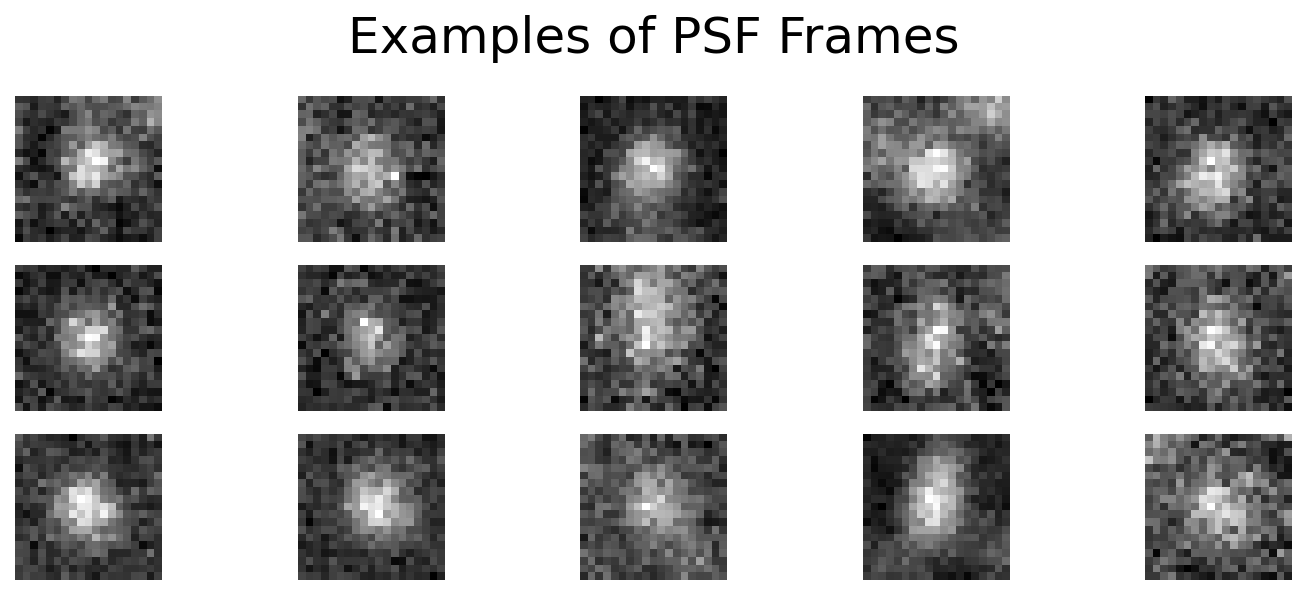

In [10]:
show_PSFs(CF660_PSFs)

In [83]:
# Assign data to classes
classes = {'A': "A647", 'B': "CF660c"}
A_raw = A647_PSFs
B_raw = CF660_PSFs

# Reduce the size of the larger dataset
if len(A_raw) < len(B_raw):
    B_raw = B_raw[np.random.choice(range(len(B_raw)), len(A_raw))]
else:
    A_raw = A_raw[np.random.choice(range(len(A_raw)), len(B_raw))]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A_raw, B_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A_raw)), np.ones(len(B_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [84]:
class PSFDataset(Dataset):
    def __init__(self, train, split=0.85, normalize=False):
        if train:
            self.images = torch.from_numpy(all_data[all_indices[:int(split*len(all_indices))]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[:int(split*len(all_indices))]]).long().cuda()
        else:
            self.images = torch.from_numpy(all_data[all_indices[int(split*len(all_indices)):]]).unsqueeze(1).cuda()
            self.labels = torch.from_numpy(labels[all_indices[int(split*len(all_indices)):]]).long().cuda()

        # Normalize the images if requested
        if normalize:
            self.images = self.normalize_images(self.images)

    def normalize_images(self, images):
        # Convert to float if necessary
        if images.dtype != torch.float32:
            images = images.float()
            
        norm = torch.norm(images.view(images.shape[0], -1), dim=1).unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        normalized_images = images / norm
        return normalized_images

    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx].float(), self.labels[idx]


# make training set
PSF_training = PSFDataset(True)
# make testing set
PSF_testing = PSFDataset(False)

print(len(PSF_training))
print(len(PSF_testing))

169607
29931


## Good Data for Post-Training Testing

In [13]:
# Load the TIFF movie for Good Data
A647_movie = tifffile.imread('Raw Data\Good Data\A647-GoatAntiMouse-No1CG-100EMG-50ms_28mW.tif')
CF660_movie = tifffile.imread('Raw Data\Good Data\CF660c-GaM_No1CG_100EMG_50ms_28mW647_0mW405.tif')
print(f"A647 Frame Count: {len(A647_movie)}")
print(f"CF660 Frame Count: {len(CF660_movie)}")

<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes


<tifffile.TiffTag 5033 @530844> coercing invalid ASCII to bytes


A647 Frame Count: 100
CF660 Frame Count: 500


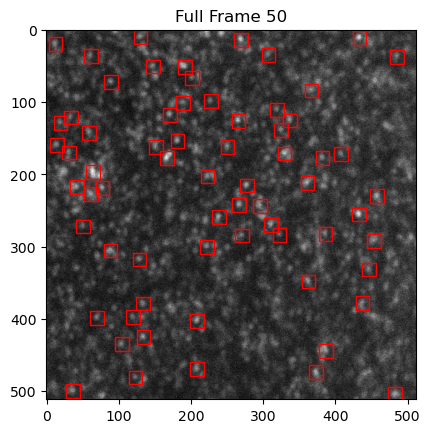

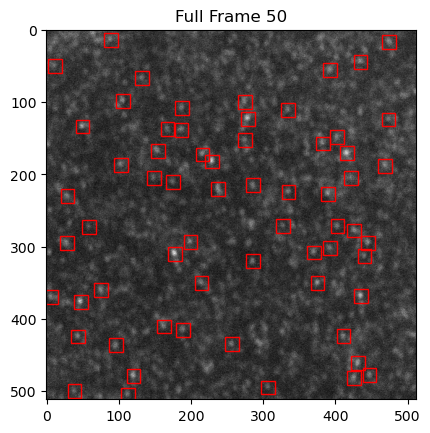

In [19]:
minmass = 3500
separation = 15
diameter = 9
frame_size = 19
percentile =99.5
indices = [50]

A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
# A647_PSF_frames = get_PSF_frames(A647_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)
CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=True, movie_frames=indices)
# CF660_PSF_frames = get_PSF_frames(CF660_movie, minmass, separation, diameter, frame_size, percentile, to_plot=False, movie_frames=True)

In [6]:
# with open('PSF Frames\A647_good_PSFs.npy', 'wb') as f:
#     np.save(f, A647_PSF_frames)
# with open('PSF Frames\CF660c_good_PSFs.npy', 'wb') as f:
#     np.save(f, CF660_PSF_frames)
with open('PSF Frames\A647_good_PSFs.npy', 'rb') as f:
    A647_PSF_frames = np.load(f)
with open('PSF Frames\CF660c_good_PSFs.npy', 'rb') as f:
    CF660_PSF_frames = np.load(f)

(6598, 19, 19)


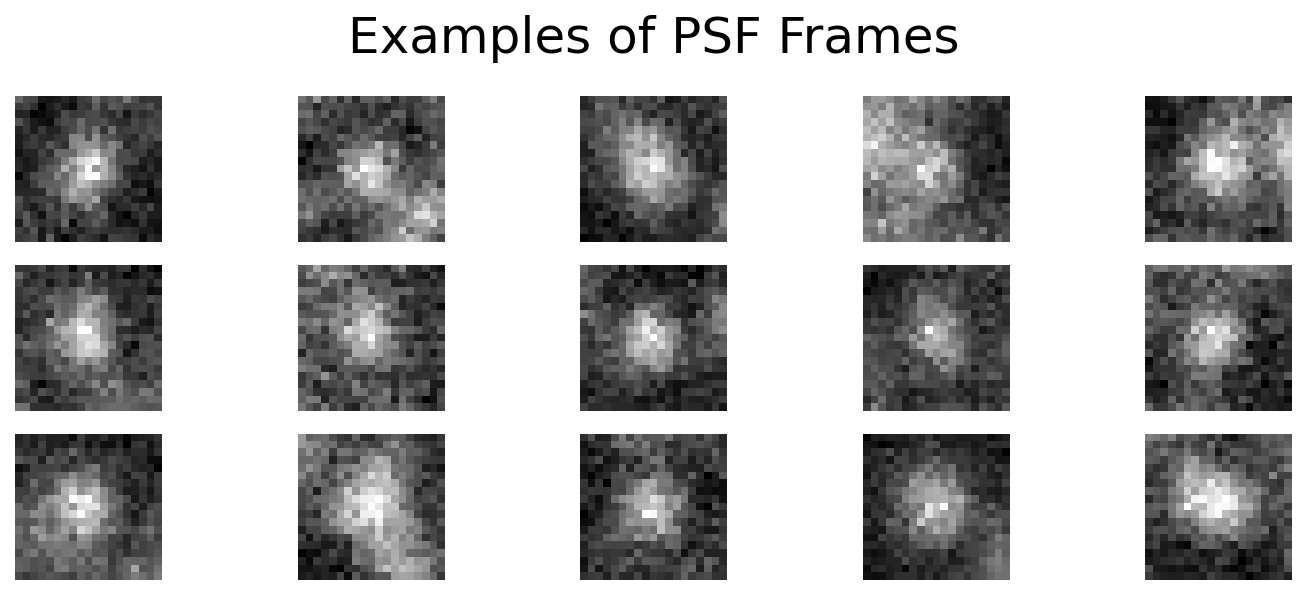

(27518, 19, 19)


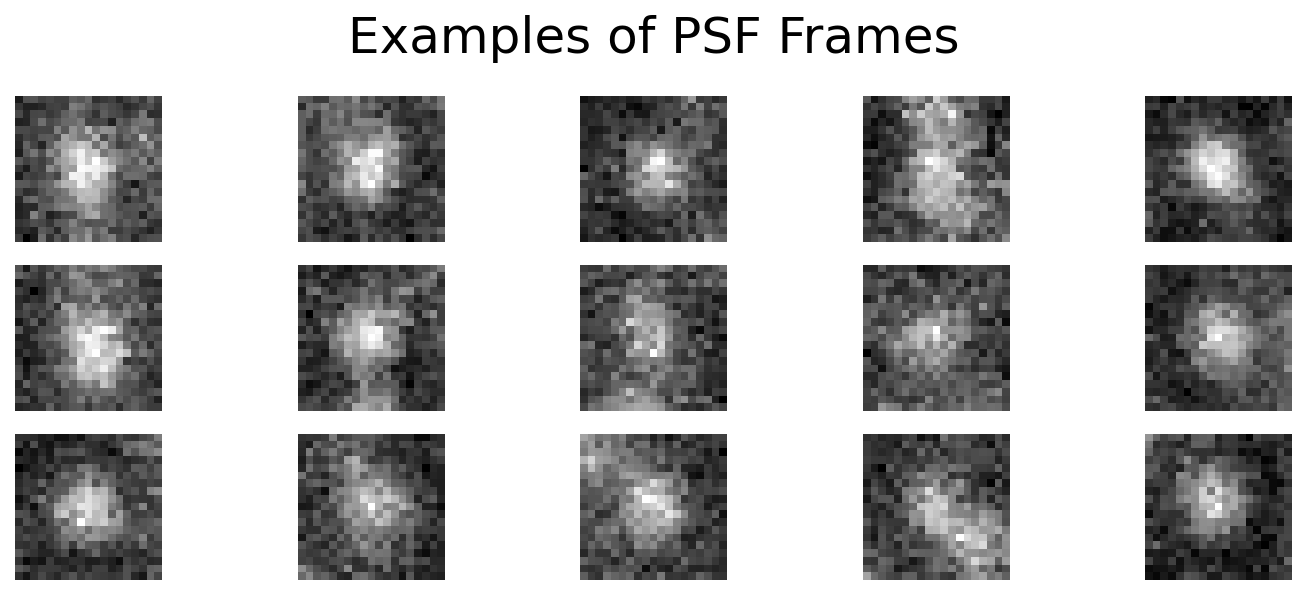

In [15]:
show_PSFs(A647_PSF_frames)
show_PSFs(CF660_PSF_frames)

In [89]:
# Assign data to classes
classes = {'A': "A647", 'B': "CF660c"}
A_raw = A647_PSF_frames
B_raw = CF660_PSF_frames

# Reduce the size of the larger dataset
if len(A_raw) < len(B_raw):
    B_raw = B_raw[np.random.choice(range(len(B_raw)), len(A_raw))]
else:
    A_raw = A_raw[np.random.choice(range(len(A_raw)), len(B_raw))]

# Combine, create labels, and reshuffle all
all_data = np.concatenate((A_raw, B_raw)).astype(np.int32)
labels = np.concatenate((np.zeros(len(A_raw)), np.ones(len(B_raw))))

random_seed = 1 # random seed for reproducibility
np.random.seed(random_seed)
all_indices = np.random.choice(np.arange(len(all_data)), size=len(all_data), replace=False)

In [90]:
# make testing set
PSF_good_testing = PSFDataset(True, split=1)
print(len(PSF_good_testing))

13196


# Model Code

## Function Definitions

In [7]:
# model code for simple convolutional nerual network followed by fully connected layers
class CNN_FC(nn.Module):
    # constructor
    def __init__(self, channel_widths, linear_sizes, kernel, pooling, nonlinearity=nn.ReLU()):
        super(CNN_FC, self).__init__()
        layers = []
        for i in range(len(channel_widths)-2):
            layers.append(nn.Conv2d(channel_widths[i], channel_widths[i+1],
                                    kernel_size=kernel, padding=2, stride=1, bias=True))
            layers.append(nonlinearity)
        layers.append(nn.Conv2d(channel_widths[-2], channel_widths[-1],
                                    kernel_size=kernel, padding=2, stride=1, bias=True))
        self.backbone = nn.Sequential(*layers)
        self.global_pooling = pooling
        self.pool_size = pooling.output_size[0]*pooling.output_size[1]

        # Defining the fully connected layers
        fc_layers = []
        in_features = channel_widths[-1]*self.pool_size
        for size in linear_sizes:
            fc_layers.append(nn.Linear(in_features, size))
            fc_layers.append(nonlinearity)
            in_features = size
        self.fully_connected = nn.Sequential(*fc_layers)

        self.linear = nn.Linear(in_features, 2)  # score each class to obtain logits

    # forward pass
    def forward(self, x):
        B = x.size(0)
        features = self.backbone(x)
        pooled_features = self.global_pooling(features)
        pooled_features = pooled_features.view(B, -1)
        fc_output = self.fully_connected(pooled_features)
        logits = self.linear(fc_output)
        return logits

In [39]:
def train(model, all_data, training_indices, validation_indices, config, verbose=False):
    # unpack configuration parameters
    lr = config['lr'] # learning rate
    n_epochs = config['n_epochs'] # number of passes (epochs) through the training data
    batch_size = config['batch_size']
    
    # set up optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # set up dataloaders
    train_sampler = torch.utils.data.SubsetRandomSampler(training_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(validation_indices)
    trainloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=val_sampler)
    
    # training loop
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_accuracy = 0
    best_model = None
    for n in range(n_epochs):
        # set model to training mode (unnecessary for this model, but good practice)
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for images, targets in trainloader:
            optimizer.zero_grad() # zero out gradients
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            loss.backward() # backpropagate to compute gradients
            optimizer.step() # update parameters using stochastic gradient descent
            # update epoch statistics
            epoch_loss += loss.item() # batch loss
            epoch_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item() # number of correct predictions
            
        # validation
        epoch_loss /= len(trainloader)
        epoch_acc /= len(training_indices)
        val_loss, val_acc = validate(model, valloader, criterion)
        val_loss /= len(valloader)
        val_acc /= len(validation_indices)
        
        # log epoch information
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        # save best model, if necessary
        if val_acc > best_val_accuracy:
            best_model = copy.deepcopy(model)
        if verbose and (n+1) % (int(n_epochs/20)) == 0:
            print('Epoch {}/{}: (Train) Loss = {:.4e}, Acc = {:.4f}, (Val) Loss = {:.4e}, Acc = {:.4f}'.format(
                   n+1,
                   n_epochs,
                   epoch_loss,
                   epoch_acc,
                   val_loss,
                   val_acc))
        
        
    return (np.array(train_losses),
            np.array(train_accuracies),
            np.array(val_losses),
            np.array(val_accuracies),
            best_model)

def train_multi(model, all_data, training_indices, validation_indices, config, 
          train_losses=[], train_accuracies=[], val_losses=[], val_accuracies=[],
          best_model=None, best_val_accuracy=0, verbose=False):
    # Convert numpy arrays to lists if necessary
    if isinstance(train_losses, np.ndarray):
        train_losses = train_losses.tolist()
    if isinstance(train_accuracies, np.ndarray):
        train_accuracies = train_accuracies.tolist()
    if isinstance(val_losses, np.ndarray):
        val_losses = val_losses.tolist()
    if isinstance(val_accuracies, np.ndarray):
        val_accuracies = val_accuracies.tolist()
    
    # unpack configuration parameters
    lr = config['lr'] # learning rate
    n_epochs = config['n_epochs'] # number of passes (epochs) through the training data
    batch_size = config['batch_size']
    
    # set up optimizer and loss function
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # set up dataloaders
    train_sampler = torch.utils.data.SubsetRandomSampler(training_indices)
    val_sampler = torch.utils.data.SubsetRandomSampler(validation_indices)
    trainloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=train_sampler)
    valloader = torch.utils.data.DataLoader(all_data, batch_size=batch_size, sampler=val_sampler)
    
    for n in range(n_epochs):
        # set model to training mode (unnecessary for this model, but good practice)
        model.train()
        epoch_loss = 0
        epoch_acc = 0
        for images, targets in trainloader:
            optimizer.zero_grad() # zero out gradients
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            loss.backward() # backpropagate to compute gradients
            optimizer.step() # update parameters using stochastic gradient descent
            # update epoch statistics
            epoch_loss += loss.item() # batch loss
            epoch_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item() # number of correct predictions
            
        # validation
        epoch_loss /= len(trainloader)
        epoch_acc /= len(training_indices)
        val_loss, val_acc = validate(model, valloader, criterion)
        val_loss /= len(valloader)
        val_acc /= len(validation_indices)
        
        # log epoch information
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # save best model, if necessary
        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            best_model = copy.deepcopy(model)
        if verbose and (n+1) % (int(n_epochs/20)) == 0:
            print('Epoch {}/{}: (Train) Loss = {:.4e}, Acc = {:.4f}, (Val) Loss = {:.4e}, Acc = {:.4f}'.format(
                   n+1,
                   n_epochs,
                   epoch_loss,
                   epoch_acc,
                   val_loss,
                   val_acc))
        
        
    return (np.array(train_losses),
            np.array(train_accuracies),
            np.array(val_losses),
            np.array(val_accuracies),
            best_model)
        
def validate(model, dataloader, criterion):
    val_loss = 0
    val_acc = 0
    # set model to eval mode (again, unnecessary here but good practice)
    model.eval()
    # don't compute gradients since we are not updating the model, saves a lot of computation
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            loss = criterion(class_logits, targets)
            val_loss += loss.item()
            val_acc += (class_logits.data.max(1)[1]).eq(targets).sum().item()
    return val_loss, val_acc

def test(model, dataset, confidence_threshold=0.6):
    # test best model on withheld test data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
    test_acc = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, targets in dataloader:
            class_logits = model(images)
            class_probabilities = torch.nn.functional.softmax(class_logits, dim=1)
            
            # Identify the predictions that are above the confidence threshold
            confident_predictions = class_probabilities.max(1)
            above_threshold_indices = confident_predictions[0] > confidence_threshold
            
            # Only consider instances where the model is confident
            confident_targets = targets[above_threshold_indices]
            confident_class_predictions = confident_predictions[1][above_threshold_indices]
            
            test_acc += (confident_class_predictions).eq(confident_targets).sum().item()
            total += len(confident_targets)
            
    return test_acc/total if total > 0 else 0

def test_with_thresholds(model, dataset, thresholds):
    # test best model on withheld test data
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128)
    model.eval()
    
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in dataloader:
            class_probs = torch.nn.functional.softmax(model(images), dim=1)
            all_probs.extend(class_probs.tolist())
            all_targets.extend(targets.tolist())

    results = []
    for threshold in thresholds:
        correct_predictions = 0
        total_predictions = 0
        rejected_predictions = 0

        for i in range(len(all_probs)):
            max_prob = max(all_probs[i])
            predicted_class = all_probs[i].index(max_prob)
            if max_prob >= threshold:
                total_predictions += 1
                if predicted_class == all_targets[i]:
                    correct_predictions += 1
            else:
                rejected_predictions += 1

        test_acc = correct_predictions / total_predictions if total_predictions > 0 else 0
        rejection_ratio = rejected_predictions / len(all_targets)
        results.append((threshold, test_acc, rejection_ratio))
    
    return results

# plot training/validation loss and accuracy over training time
def plot_model_results():
    plt.figure(figsize=(15, 10))
    plt.subplot(221)
    plt.semilogy(train_losses, color='royalblue')
    plt.xlabel('Epoch')
    plt.title('Training loss')
    plt.grid(True)
    plt.subplot(222)
    plt.plot(train_accs, color='darkorange')
    plt.xlabel('Epoch')
    plt.title('Training accuracy')
    plt.grid(True)
    plt.subplot(223)
    plt.plot(val_losses, color='royalblue')
    plt.xlabel('Epoch')
    plt.title('Validation loss')
    plt.grid(True)
    plt.subplot(224)
    plt.plot(val_accs, color='darkorange')
    plt.xlabel('Epoch')
    plt.title('Validation accuracy')
    plt.grid(True)

## Training and Testing

### Model 11

In [17]:
# metrics visualization

# data
# you can try playing around with more or less training data
N_training_examples = 10000 # 100 examples per class
N_validation_examples = 5000 # 100 examples per class
random_seed = 2 # random seed for reproducibility
np.random.seed(random_seed)
all_train_indices = np.random.choice(np.arange(len(PSF_training)),
                               size=2*N_training_examples+N_validation_examples)
# Make two unique training/validation sets for change partway through training if desired
all_train_indices_1 = all_train_indices[:int(len(all_train_indices)/2)]
all_train_indices_2 = all_train_indices[int(len(all_train_indices)/2):]
training_indices_1 = all_train_indices_1[:N_training_examples]
validation_indices_1 = all_train_indices_1[N_training_examples:]
training_indices_2 = all_train_indices_2[:N_training_examples]
validation_indices_2 = all_train_indices_2[N_training_examples:]

# configuration parameters, you can play around with these
pooling = 'max' # 'max' or 'mean'

if pooling == 'max':
    pool_fcn = nn.AdaptiveMaxPool2d((1, 1))
else:
    pool_fcn = nn.AdaptiveAvgPool2d((1, 1))
# model
# your model will have length(channel_widths)-1 layers
channel_widths = [1, 128, 128, 256, 256, 512] # must start with a 1 and be at least length--2
linear_sizes = [1024, 64]
kernel = 3
model_11 = CNN_FC(channel_widths, linear_sizes, kernel, pool_fcn)

In [18]:
config = {'lr': 1e-3,
          'n_epochs': 100,
          'batch_size': 512}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train(model_11.cuda(),
                                                                   PSF_training,
                                                                   training_indices_1,
                                                                   validation_indices_1,
                                                                   config,
                                                                   verbose=verbose)

Epoch 5/100: (Train) Loss = 6.4220e-01, Acc = 0.6141, (Val) Loss = 6.4666e-01, Acc = 0.5112
Epoch 10/100: (Train) Loss = 5.9204e-01, Acc = 0.7021, (Val) Loss = 5.8292e-01, Acc = 0.7368
Epoch 15/100: (Train) Loss = 6.0127e-01, Acc = 0.6699, (Val) Loss = 5.8458e-01, Acc = 0.7848
Epoch 20/100: (Train) Loss = 6.2226e-01, Acc = 0.6302, (Val) Loss = 5.8504e-01, Acc = 0.6140
Epoch 25/100: (Train) Loss = 5.7795e-01, Acc = 0.6984, (Val) Loss = 6.1405e-01, Acc = 0.5492
Epoch 30/100: (Train) Loss = 6.1482e-01, Acc = 0.6289, (Val) Loss = 5.3121e-01, Acc = 0.7408
Epoch 35/100: (Train) Loss = 5.5067e-01, Acc = 0.7229, (Val) Loss = 5.6106e-01, Acc = 0.6132
Epoch 40/100: (Train) Loss = 5.6051e-01, Acc = 0.6865, (Val) Loss = 6.3276e-01, Acc = 0.5460
Epoch 45/100: (Train) Loss = 5.2967e-01, Acc = 0.7264, (Val) Loss = 5.1812e-01, Acc = 0.7900
Epoch 50/100: (Train) Loss = 5.3837e-01, Acc = 0.7250, (Val) Loss = 4.8629e-01, Acc = 0.8176
Epoch 55/100: (Train) Loss = 4.9378e-01, Acc = 0.7525, (Val) Loss = 4.3

In [26]:
config = {'lr': 1e-4,
          'n_epochs': 20,
          'batch_size': 512}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train_multi(best_model.cuda(),
                                                                   PSF_training,
                                                                   training_indices_2,
                                                                   validation_indices_1,
                                                                   config,
                                                                   train_losses=train_losses,
                                                                   train_accuracies=train_accs,
                                                                   val_losses=val_losses,
                                                                   val_accuracies=val_accs,
                                                                   best_model=best_model,
                                                                   verbose=verbose)

Epoch 1/20: (Train) Loss = 3.4913e-01, Acc = 0.8694, (Val) Loss = 3.3705e-01, Acc = 0.8700
Epoch 2/20: (Train) Loss = 3.4618e-01, Acc = 0.8703, (Val) Loss = 3.3459e-01, Acc = 0.8688
Epoch 3/20: (Train) Loss = 3.4506e-01, Acc = 0.8696, (Val) Loss = 3.3366e-01, Acc = 0.8696
Epoch 4/20: (Train) Loss = 3.4283e-01, Acc = 0.8712, (Val) Loss = 3.3280e-01, Acc = 0.8708
Epoch 5/20: (Train) Loss = 3.4292e-01, Acc = 0.8713, (Val) Loss = 3.3214e-01, Acc = 0.8700
Epoch 6/20: (Train) Loss = 3.4297e-01, Acc = 0.8709, (Val) Loss = 3.3021e-01, Acc = 0.8700
Epoch 7/20: (Train) Loss = 3.4091e-01, Acc = 0.8709, (Val) Loss = 3.3024e-01, Acc = 0.8708
Epoch 8/20: (Train) Loss = 3.4067e-01, Acc = 0.8716, (Val) Loss = 3.2935e-01, Acc = 0.8728
Epoch 9/20: (Train) Loss = 3.3822e-01, Acc = 0.8717, (Val) Loss = 3.2789e-01, Acc = 0.8728
Epoch 10/20: (Train) Loss = 3.3820e-01, Acc = 0.8724, (Val) Loss = 3.2814e-01, Acc = 0.8724
Epoch 11/20: (Train) Loss = 3.3826e-01, Acc = 0.8721, (Val) Loss = 3.2635e-01, Acc = 0.87

In [73]:
config = {'lr': 3e-4,
          'n_epochs': 20,
          'batch_size': 512}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train_multi(best_model.cuda(),
                                                                   PSF_training,
                                                                   training_indices_2,
                                                                   validation_indices_1,
                                                                   config,
                                                                   train_losses=train_losses,
                                                                   train_accuracies=train_accs,
                                                                   val_losses=val_losses,
                                                                   val_accuracies=val_accs,
                                                                   best_model=best_model,
                                                                   verbose=verbose)

Epoch 1/20: (Train) Loss = 3.3370e-01, Acc = 0.8744, (Val) Loss = 3.2095e-01, Acc = 0.8756
Epoch 2/20: (Train) Loss = 3.3039e-01, Acc = 0.8748, (Val) Loss = 3.2110e-01, Acc = 0.8752
Epoch 3/20: (Train) Loss = 3.3008e-01, Acc = 0.8750, (Val) Loss = 3.1891e-01, Acc = 0.8764
Epoch 4/20: (Train) Loss = 3.2798e-01, Acc = 0.8771, (Val) Loss = 3.1820e-01, Acc = 0.8768
Epoch 5/20: (Train) Loss = 3.2740e-01, Acc = 0.8749, (Val) Loss = 3.1602e-01, Acc = 0.8772
Epoch 6/20: (Train) Loss = 3.2594e-01, Acc = 0.8774, (Val) Loss = 3.1570e-01, Acc = 0.8804
Epoch 7/20: (Train) Loss = 3.2702e-01, Acc = 0.8771, (Val) Loss = 3.1741e-01, Acc = 0.8792
Epoch 8/20: (Train) Loss = 3.2600e-01, Acc = 0.8753, (Val) Loss = 3.1514e-01, Acc = 0.8776
Epoch 9/20: (Train) Loss = 3.2371e-01, Acc = 0.8794, (Val) Loss = 3.1464e-01, Acc = 0.8764
Epoch 10/20: (Train) Loss = 3.2256e-01, Acc = 0.8785, (Val) Loss = 3.1408e-01, Acc = 0.8768
Epoch 11/20: (Train) Loss = 3.2196e-01, Acc = 0.8788, (Val) Loss = 3.1209e-01, Acc = 0.87

In [76]:
config = {'lr': 5e-4,
          'n_epochs': 20,
          'batch_size': 512}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train_multi(best_model.cuda(),
                                                                   PSF_training,
                                                                   training_indices_2,
                                                                   validation_indices_1,
                                                                   config,
                                                                   train_losses=train_losses,
                                                                   train_accuracies=train_accs,
                                                                   val_losses=val_losses,
                                                                   val_accuracies=val_accs,
                                                                   best_model=best_model,
                                                                   verbose=verbose)

Epoch 1/20: (Train) Loss = 3.2228e-01, Acc = 0.8777, (Val) Loss = 3.0819e-01, Acc = 0.8824
Epoch 2/20: (Train) Loss = 3.1477e-01, Acc = 0.8843, (Val) Loss = 3.0653e-01, Acc = 0.8828
Epoch 3/20: (Train) Loss = 3.1260e-01, Acc = 0.8836, (Val) Loss = 3.0422e-01, Acc = 0.8836
Epoch 4/20: (Train) Loss = 3.1459e-01, Acc = 0.8804, (Val) Loss = 3.3770e-01, Acc = 0.8524
Epoch 5/20: (Train) Loss = 3.1613e-01, Acc = 0.8779, (Val) Loss = 3.0450e-01, Acc = 0.8864
Epoch 6/20: (Train) Loss = 3.1312e-01, Acc = 0.8798, (Val) Loss = 3.2628e-01, Acc = 0.8748
Epoch 7/20: (Train) Loss = 3.2469e-01, Acc = 0.8709, (Val) Loss = 3.0230e-01, Acc = 0.8812
Epoch 8/20: (Train) Loss = 3.0662e-01, Acc = 0.8875, (Val) Loss = 3.2758e-01, Acc = 0.8748
Epoch 9/20: (Train) Loss = 3.1787e-01, Acc = 0.8805, (Val) Loss = 3.1270e-01, Acc = 0.8788
Epoch 10/20: (Train) Loss = 3.2505e-01, Acc = 0.8718, (Val) Loss = 3.4155e-01, Acc = 0.8488
Epoch 11/20: (Train) Loss = 3.0679e-01, Acc = 0.8846, (Val) Loss = 2.9888e-01, Acc = 0.88

In [85]:
config = {'lr': 3e-4,
          'n_epochs': 20,
          'batch_size': 512}
# train
verbose = True # print metrics during training, False for no printing
train_losses, train_accs, val_losses, val_accs, best_model = train_multi(best_model.cuda(),
                                                                   PSF_training,
                                                                   training_indices_2,
                                                                   validation_indices_1,
                                                                   config,
                                                                   train_losses=train_losses,
                                                                   train_accuracies=train_accs,
                                                                   val_losses=val_losses,
                                                                   val_accuracies=val_accs,
                                                                   best_model=best_model,
                                                                   verbose=verbose)

Epoch 1/20: (Train) Loss = 3.0227e-01, Acc = 0.8830, (Val) Loss = 3.0247e-01, Acc = 0.8732
Epoch 2/20: (Train) Loss = 3.0089e-01, Acc = 0.8846, (Val) Loss = 2.9604e-01, Acc = 0.8896
Epoch 3/20: (Train) Loss = 3.0119e-01, Acc = 0.8859, (Val) Loss = 2.9599e-01, Acc = 0.8880
Epoch 4/20: (Train) Loss = 2.9989e-01, Acc = 0.8842, (Val) Loss = 2.9737e-01, Acc = 0.8800
Epoch 5/20: (Train) Loss = 2.9907e-01, Acc = 0.8868, (Val) Loss = 3.0189e-01, Acc = 0.8752
Epoch 6/20: (Train) Loss = 2.9920e-01, Acc = 0.8877, (Val) Loss = 3.0165e-01, Acc = 0.8856
Epoch 7/20: (Train) Loss = 2.9937e-01, Acc = 0.8876, (Val) Loss = 2.9147e-01, Acc = 0.8924
Epoch 8/20: (Train) Loss = 2.9653e-01, Acc = 0.8892, (Val) Loss = 2.9170e-01, Acc = 0.8924
Epoch 9/20: (Train) Loss = 2.9775e-01, Acc = 0.8851, (Val) Loss = 2.9202e-01, Acc = 0.8904
Epoch 10/20: (Train) Loss = 2.9637e-01, Acc = 0.8896, (Val) Loss = 2.9883e-01, Acc = 0.8896
Epoch 11/20: (Train) Loss = 2.9396e-01, Acc = 0.8890, (Val) Loss = 2.9195e-01, Acc = 0.89

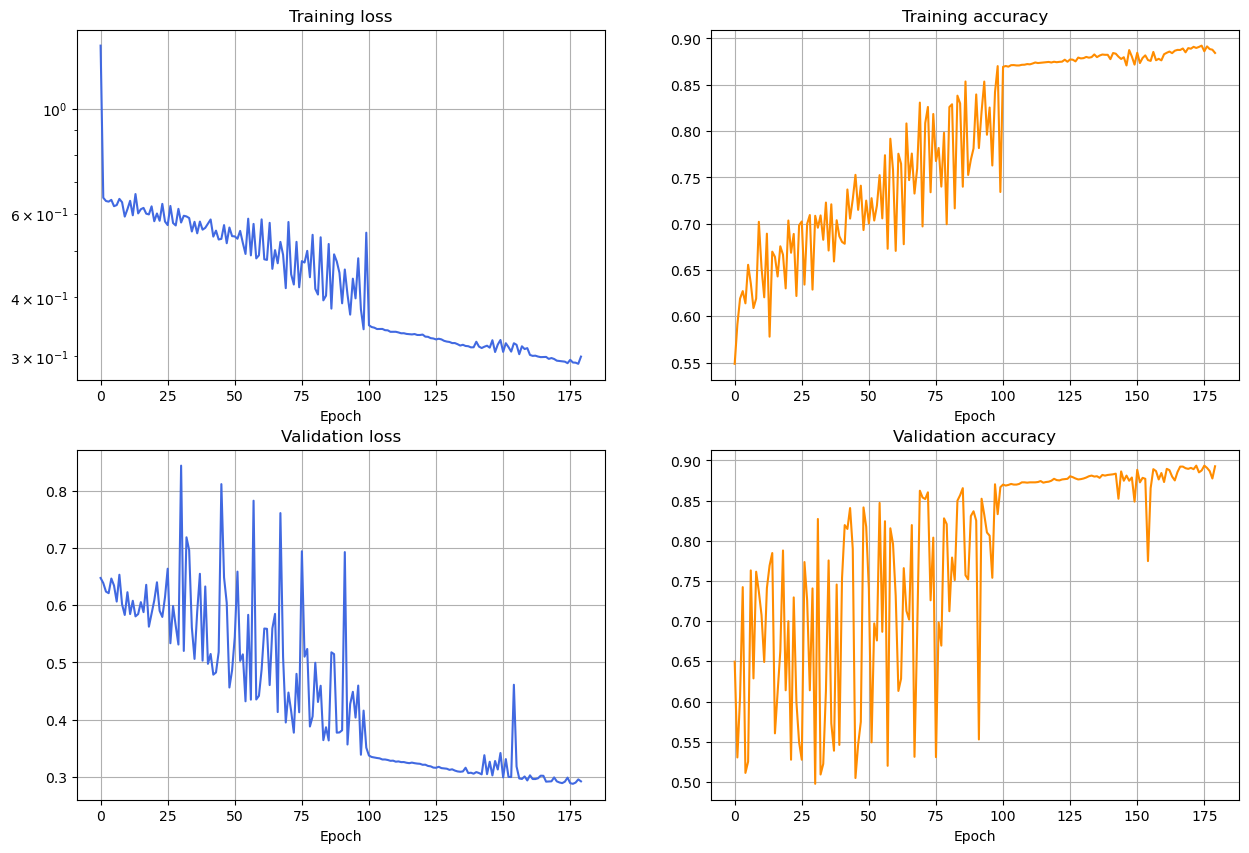

In [86]:
# plot training/validation loss and accuracy over training time
plot_model_results()

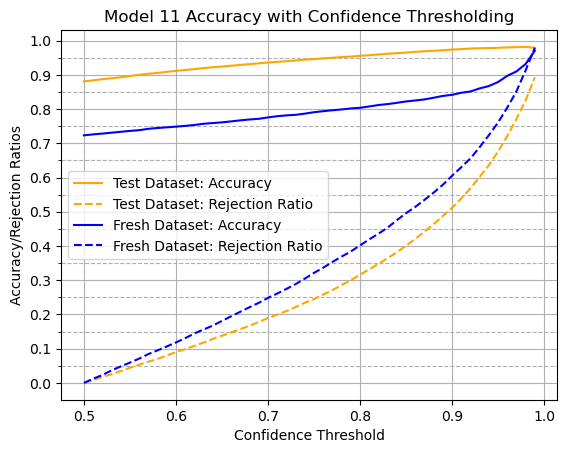

In [87]:
test_results = np.array(test_with_thresholds(best_model, PSF_testing, np.arange(0.5, 1, 0.01)))
fresh_test_results = np.array(test_with_thresholds(best_model, PSF_good_testing, np.arange(0.5, 1, 0.01)))

plt.figure()
plt.plot(test_results[:, 0], test_results[:, 1], color='orange', label='Test Dataset: Accuracy')
plt.plot(test_results[:, 0], test_results[:, 2], color='orange', linestyle='--', label='Test Dataset: Rejection Ratio')
plt.plot(fresh_test_results[:, 0], fresh_test_results[:, 1], color='blue', label='Fresh Dataset: Accuracy')
plt.plot(fresh_test_results[:, 0], fresh_test_results[:, 2], color='blue', linestyle='--', label='Fresh Dataset: Rejection Ratio')
plt.legend()
plt.yticks(np.arange(0, 1, 0.05), minor=True)
plt.yticks(np.arange(0, 1.1, 0.1), minor=False)

plt.grid(True, which='major')
plt.grid(True, which='minor', ls='--')
plt.ylabel("Accuracy/Rejection Ratios")
plt.xlabel("Confidence Threshold")
plt.title("Model 11 Accuracy with Confidence Thresholding")
plt.grid
plt.show()

In [98]:
torch.save(model_11, 'Models/model11.pt')